In [19]:
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy import transpose
import numpy as np
from math import sqrt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from time import time
import seaborn as sns
#tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.0.0


In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#c = tf.matmul(a, b)

#print(c)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15788605075636717930
]


In [21]:
X_train_df = read_csv('X_train.csv', index_col=0)
X_val_df = read_csv('X_val.csv', index_col=0)
test_df = read_csv('X_test.csv', index_col=0)
y_train_df = read_csv('y_train.csv', index_col=0)
y_val_df = read_csv('y_val.csv', index_col=0)

In [22]:
y_train_df.shape

(1049, 1)

### Output scaling

In [23]:
scaler_Y = StandardScaler()
scaler_Y.fit(y_train_df)

y_train = scaler_Y.transform(y_train_df)
y_val = scaler_Y.transform(y_val_df)

In [18]:
y_train = y_train.SalePrice.values.astype(float)
y_val = y_val.SalePrice.values.astype(float)

In [134]:
X_train = transpose([X_train.Surface.values.astype(float)])
X_val = transpose([X_val.Surface.values.astype(float)])

In [24]:
X_train_df.shape

(1049, 122)

In [25]:
#X_train = X_train[['Surface','OverallQual']].values.astype(float)
#X_val = X_val[['Surface','OverallQual']].values.astype(float)
X_train = X_train_df.values.astype(float)
X_val = X_val_df.values.astype(float)
test = test_df.values.astype(float)

In [26]:
nb_features = 75 # 24
X_train = X_train[:,:nb_features]
X_val = X_val[:,:nb_features]
test = test[:,:nb_features]

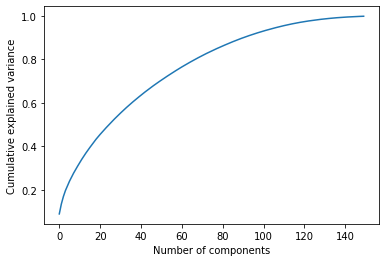

In [180]:
nb_features = 150
pca = PCA(n_components=nb_features)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
X_train=pca.transform(X_train)
X_val=pca.transform(X_val)
test=pca.transform(test)


In [27]:
X_train.shape

(1049, 75)

In [28]:
from tensorflow.keras.backend import sigmoid, tanh, maximum
def custom(x):
    return maximum(x,tanh(x))

In [29]:
def get_reg_model():
    return Sequential([
                    Input(shape=X_train.shape[1]),
                    Dense(1)
])

In [30]:
def get_other_model():
    return Sequential([
                    Input(shape=X_train.shape[1]),
                    Dense(32, kernel_regularizer=regularizers.l1(0.001)),
                    Activation('tanh', activity_regularizer=regularizers.l1(0.001)),
#                    Dense(32, kernel_regularizer=regularizers.l1(0.001)),
#                    Activation('tanh', activity_regularizer=regularizers.l1(0.001)),
                    Dense(1)
])

In [31]:
def get_noregu_model():
    return Sequential([
                    Input(shape=X_train.shape[1]),
                    Dense(32),
                    Activation('softplus'),
#                    Dense(32),
#                    Activation('tanh'),
                    Dense(1)
])

In [32]:
loss = 'mse'
LEARNING_RATE = 0.01

In [33]:
model = get_reg_model()
model.compile(loss=loss, optimizer=SGD(lr=LEARNING_RATE))
BATCH_SIZE = X_train.shape[0] # computing the loss over the whole dataset
EPOCHS = 750 # how many iterations over the whole dataset
t_0 = time()
#with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train,  validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

print(time()-t_0, 's')

8.114405393600464 s


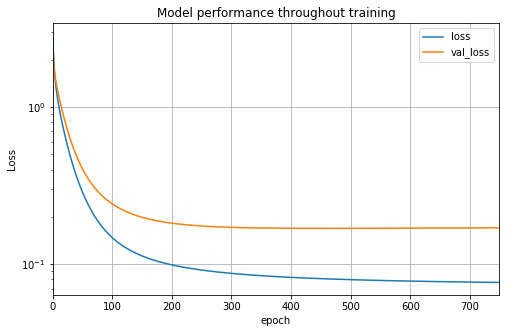

In [34]:
DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
y_p_scaled = model.predict(X_val)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])
y_p = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_val_df,y_p))
print('Validation RMSLE:', RMSLE)
y_p_scaled = model.predict(X_train)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])

y_p = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_train_df.SalePrice,y_p))
print('Train RMSLE:', RMSLE)

Validation RMSLE: 0.1506580125399478
Train RMSLE: 0.1009574743344544


In [36]:
test_pred_log_scaled = model.predict(test)
test_pred_log = scaler_Y.inverse_transform(test_pred_log_scaled)
test_pred = np.exp(test_pred_log).reshape(test_pred_log.shape[0])
submission = DataFrame({"SalePrice": test_pred}, index=test_df.index)
submission.to_csv('test-prediction-keras-lin.csv')

In [37]:
model = get_other_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                2432      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [38]:
LEARNING_RATE=0.05
model.compile(loss=loss, optimizer=SGD(lr=LEARNING_RATE))
#model.compile(loss=loss, optimizer=RMSprop(lr=LEARNING_RATE))
#model.compile(loss=loss, optimizer=Adam(lr=LEARNING_RATE))

In [39]:
BATCH_SIZE = X_train.shape[0] # computing the loss over the whole dataset
EPOCHS = 50000 # how many iterations over the whole dataset
t_0 = time()
#with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print(time()-t_0)

464.09608578681946


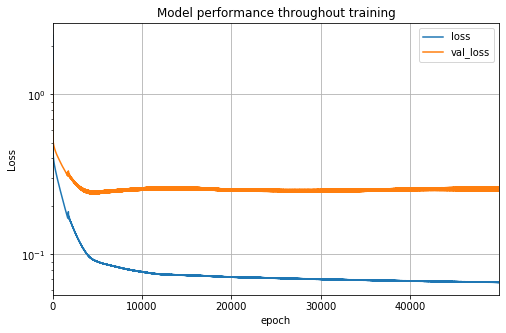

In [40]:
DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
y_p_scaled = model.predict(X_val)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])
y_p_val = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_val_df,y_p_val))
print('Validation RMSLE:', RMSLE)
y_p_scaled = model.predict(X_train)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])

y_p_train = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_train_df.SalePrice, y_p_train))
print('Train RMSLE:', RMSLE)

Validation RMSLE: 0.17380673267614266
Train RMSLE: 0.06464777222708702


In [42]:
test_pred_log_scaled = model.predict(test)
test_pred_log = scaler_Y.inverse_transform(test_pred_log_scaled)
test_pred = np.exp(test_pred_log).reshape(test_pred.shape[0])
submission = DataFrame({"SalePrice": test_pred}, index=test_df.index)
submission.to_csv('test-prediction-keras-1hiddenLayer.csv')

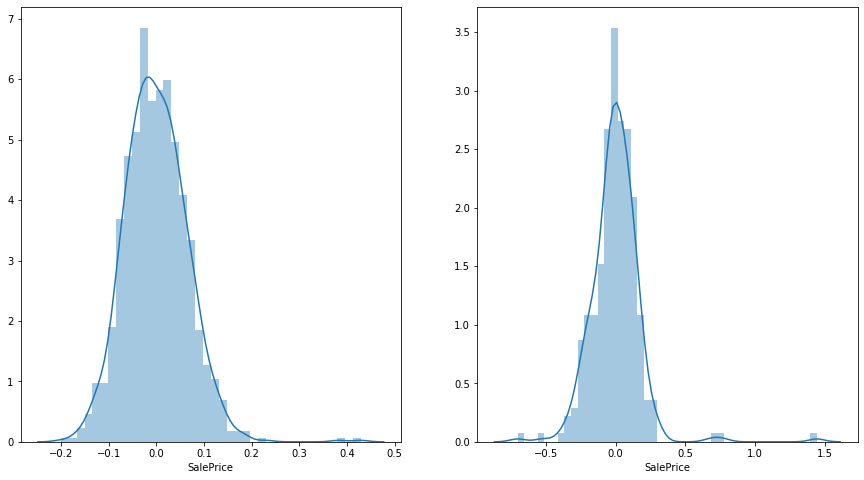

In [43]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.distplot(y_p_train-y_train_df.SalePrice)
plt.subplot(1,2,2)
sns.distplot(y_p_val-y_val_df.SalePrice)
plt.show()

(1049,)


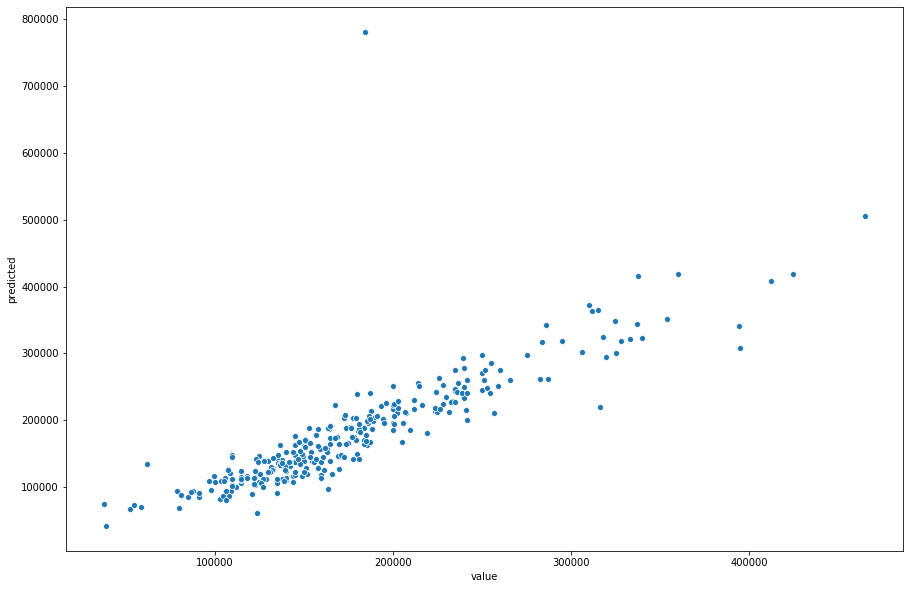

In [44]:
y = y_val_df.SalePrice.to_numpy()
y = y.reshape(y.shape[0])
print(y_p_train.shape)
df = DataFrame(data={'value':np.exp(y), 'predicted':np.exp(y_p_val)},index=y_val_df.index)
plt.figure(figsize=(15,10))
sns.scatterplot(x='value',y='predicted', data=df )
plt.show()

In [45]:
anomaly_idx = df['predicted'].idxmax()
print(anomaly_idx)

524


In [46]:
anomaly = X_val_df.loc[anomaly_idx]

In [47]:
anomaly.loc[np.abs(anomaly)>1.5]

Surface                  6.628896
OverallQual              2.824970
KitchenQual_ord          2.274398
BsmtQual_ord             1.703280
Condition1_Norm         -2.498447
SaleType_New             3.301206
ExterQual_ord            2.807580
GarageArea               1.948454
MasVnrType_Stone         3.338538
BsmtExposure_Gd          3.178799
RoofStyle_Hip            2.001073
FullBath                 2.614849
LotArea                  3.283105
GarageFinish_Fin         1.718296
TotalBsmtSF              4.881511
OpenPorchSF              5.380255
1stFlrSF                 5.232092
2ndFlrSF                 2.740429
BsmtFinSF1               4.210999
LandContour_Lvl         -2.980160
Neighborhood_Edwards     3.734798
GarageCars               1.634322
LotFrontage              3.046534
TotRmsAbvGrd             2.800135
SaleCondition_Normal    -2.133631
MasVnrArea               3.721816
SaleCondition_Partial    3.264966
LandContour_Bnk          4.582576
BsmtFinType1_GLQ         1.618987
RoofStyle_Gabl